# Principal Component Analysis Workshop
In this workshop, you will perform an important data analysis procedure called principal components analysis (PCA). After a brief introduction on linear algebra and dimensionality reduction, you will attempt to write your own PCA class.

In [2]:
#@Install scanpy (needed for PBMC)
!pip install scanpy

     |████████████████████████████████| 7.2MB 2.8MB/s 
     |████████████████████████████████| 102kB 12.8MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy 
import scanpy as sc
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('drive/My Drive/BME230B/Homework_2/')

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Introduction - Matrices, eigenvectors and PCA

#### **Matrices**
Matrices are mathematical objects that are useful to represent both datasets and *linear* transformations. Actually, matrices have been developped for the purpose of representing a system of linear equations.
Here, we will look at matrices as transformations, since it makes it easier to understand some of the concepts introduced in this workshop. 

#### **Eigenvectors**
Consider a matrix $\mathbf{A}$. We define the set of eigenvectors of $\mathbf{A}$ as the set of vectors $\vec{v}$ verifying:

\begin{align}
  \mathbf{A}\vec{v} = \lambda\vec{v} \nonumber
\end{align}

where $\lambda$ is a scalar called an *eigenvalue* associated to $\vec{v}$.

The geometrical intuition behind an eigenvector is that it is one of those special vectors whose direction remains unchanged when applying the transformation $\mathbf{A}$ (*ie* multiplying by $\mathbf{A}$); they are simply re-scaled by a value $\lambda$. Let's look at an example with:

\begin{align}
  \mathbf{A} = \begin{pmatrix} 1 & -1 \\
  0 & 2 
  \end{pmatrix}
\end{align}

Now consider $\vec{v}=(-1,1)$ and $\vec{w}=(2,1)$. We apply the transformation by multiplying each vector by $\mathbf{A}$. Look at how each vector is affected.

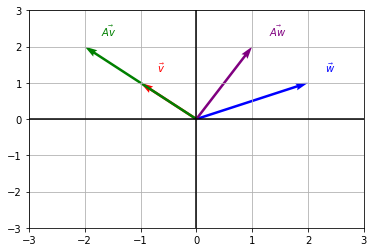

In [0]:
#@title Visualize eigenvectors
# Initialize matrix and some vectors
origin = [0], [0]
A = np.array([[1,-1],[0,2]])
v = np.array([-1,1])
w = np.array([2,1])
# Transform vectors
v_tr = A @ v
w_tr = A @ w
# Plot non transformed and transformed vectors
plt.quiver(*origin, v[0], v[1], color='r', angles='xy', scale_units='xy', scale=1, label='v')
plt.annotate(r'$\vec{v}$', v+0.3, c='r')
plt.quiver(*origin, w[0], w[1], color='b', angles='xy', scale_units='xy', scale=1, label='w')
plt.annotate(r'$\vec{w}$', w+0.3, c='b')
plt.quiver(*origin, v_tr[0], v_tr[1], color='g', angles='xy', scale_units='xy', scale=1, label='A.v')
plt.annotate(r'$\vec{Av}$', v_tr+0.3, c='g')
plt.quiver(*origin, w_tr[0], w_tr[1], color='purple', angles='xy', scale_units='xy', scale=1, label='A.w')
plt.annotate(r'$\vec{Aw}$', w_tr+0.3, c='purple')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.grid()
#plt.legend()
plt.show()

Notice how the direction of $\vec{v}$ hasn't been changed after multiplying by $\mathbf{A}$, it has just been re-scaled by a factor of 2. We say that $\vec{v}$ is an eigenvector of $\mathbf{A}$ and its associated eigenvalue is $\lambda=2$. $\vec{w}$ is not an eigenvector since its direction changed.

Often, eigendecomposition (finding the eigenvectors and associated eigenvalues) of a matrix is useful to study its properties, or provide a new system of coordinate (eigenbasis) where the eigenvectors are the new 'axis'. To read more about it, you can refer to https://www.deeplearningbook.org/contents/linear_algebra.html

#### **Dimensionality reduction**
As mentioned before, matrices are also useful to represent datasets. Usually, the rows of a matrix represent the *samples* of a dataset (the objects we measured) and the columns the *features* (characteristics of each object). Often, some of the features are correlated, which means that the information can be compressed into a reduced set of features to improve computational performance in downstream analysis. Also, the number of features is usually too high to allow us to directly visualize it (how would you plot a 27-D vector?). Therefore, we use dimensionality reduction: a set of methods aiming at embedding the data points into a lower dimension so that we can visualize it. They come in different flavors, with different objective functions (criterion for a successful embedding of the data). The goal of this workshop is to focus on one of them, Principal Component Analysis.

#### **Principal Component Analysis**

Principal Component Analysis (PCA) is a data analysis method originally developed by Pearson (1901). This method can be seen as finding a new system of coordinates to embed the data points such that the variance of the data along each axis is maximized. This sounds cryptic but think about this: how can I find a new space for my dataset where the samples 'separate' by how correlated they are? Ideally you would like similar (correlated) datapoints to be closer to each other in that space, and further from each other the less correlated they are. 


PCA achieves this goal by finding the directions of most variance in the data. Although it can be looked at from different angles, the concept of an eigenvector is really helpful to understand this. 

Consider a dataset with $N$ samples and $P$ features represented by the matrix $\mathbf{X}$. Remember that the covariance matrix $\mathbf{Q}$ is a matrix that tells us how much a feature varies with another one in $\mathbf{X}$. An element $q_{j,k}$ of this matrix is the covariance between features $\mathbf{x}_j$ and $\mathbf{x}_k$ of the data matrix $\mathbf{X}$, and is defined as:

\begin{align}
  q_{j,k}=Cov(\mathbf{x}_j, \mathbf{x}_k) = \frac{1}{N-1}\sum_{i=1}^N(x_{i,j}-\bar{x}_j)(x_{i,k}-\bar{x}_k)
\end{align}


You can see that the matrix $\mathbf{Q}$ is symmetric. The spectral theorem tells us that the eigendecomposition of a symmetric matrix $n \times n$ will give us exactly $n$ eigenvalues and orthogonal eigenvectors. The eigenvectors of the covariance matrix gives us a set of orthogonal vectors representing this new coordinate system where the spread of the data is maximized. To embed the data into this new space, we simply multiply the data matrix by the matrix of eigenvectors, which has the effect of projecting the points into the new space. By keeping only $k$ eigenvectors (called *principal components* in this case), we can embed the data into a $k$ dimensional space. 


An interesting property of the covariance matrix is that the diagonal elements represent the variance of each feature in the data. By summing across the diagonal (also called the *trace* of the matrix), we can find the total amount of variance in the data. Sorting eigenvectors of the covariance matrix in the decreasing order of their eigenvalues is the same as sorting the 'directions' in decreasing order of contribution to the total variance: the eigenvalue of each principal component tells us the proportion of the total variance explained by each vector.

Note that each feature should be centered prior to PCA, meaning that the mean of each feature is 0 (simply done by substracting the mean to each value). This simplifies computation of the covariance matrix but also have important consequences for PCA. 

### Coding PCA from scratch
In this part, you will code PCA from scratch. We will first work with the Iris dataset, a classic machine learning dataset, and later work with an actual RNA-sequencing single-cell dataset.
The following piece of code loads the data into a matrix (X) and centers it so that the mean is 0 columnwise. Your goal is to implement a PCA tool such that:


1.   It computes the covariance of the dataset
2.   It decomposes the covariance matrix into its eigenspace
3.   It selects $k=2$ components to be used for embedding
4.   It embeds (transform) the original data and plots the result
5.   It creates a plot showing the proportion of variance explained by each component (called a *Skree plot*)



In [0]:
# Load iris data
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
Y = iris.target

# First we need to center the data
X = X - X.mean(axis=0)

In [0]:
# Code to fill as exercise
class my_PCA:
    def __init__(self, n_comp):
        """Constructor for class PCA. Specify number of component to use for embedding.
        """
        self.n_comp = n_comp
        self.tot_var = 0
        self.cov = np.array([])
        self.eigval = np.array([])
        self.eigvec = np.array([])

    def fit(self, X):
        """
        Compute principal components from input data. This should compute the 
        covariance matrix and the full eigendecomposition of the matrix.
        """
        # Correct n_comp if needed
        if self.n_comp > min(X.shape):
            self.n_comp = min(X.shape)
        # Build covariance matrix
        self.cov = self.construct_covariance(X)
        # Get total variance
        self.tot_var = np.trace(self.cov)
        # Decompose
        self.eigval, self.eigvec = self.decompose_cov(self.cov)
        return


    def construct_covariance(self, X):
        """
        Construct covariance matrix from input data. The covariance matrix should be
        have dimension feature x feature. You can fill the matrix element by element
        (remember we already subtracted the mean of each column) or hint: 
        Think how you can use matrix operation to compute it with a single line.
        """
        # Fill code here
        cov_mat = np.zeros((self.n_comp, self.n_comp))
        for j in range(self.n_comp):
            for k in range(self.n_comp):
                cov_mat[j, k] = np.dot(X[:,j], X[:,k])

        return cov_mat


    def decompose_cov(self, cov):
        """
        Performs eigendecomposition on covariance matrix. Remember to 
        sort eigenvalue AND  eigenvector in descending order 
        (largest eigenvalue and associated eigenvector first).
        """
        # Fill code here
        # ...
        eig_val, eig_vec = np.linalg.eig(cov)

        return eig_val, eig_vec

    def transform(self, X):
        """
        Embed input data into new space. Use input k components to transform data.
        """
        # Fill code here

        # since k = 2 we only use first 2 values.
        transformed_data = np.dot(X[:,:self.n_comp], self.eigvec)

        return transformed_data

    def variance_explained(self):
        """
        Plot skree plot for variance explained per PC.
        Compute the proportion (%) of the total variance explain by each eigenvector.
        Plot it.
        """
        # Fill code here - This function doesn't return anything but plot
        # ... 
        x_pos = [i+1 for i in range(len(self.eigval))]
        plt.plot(x_pos, self.eigval, linewidth=3, mec= 'b', mfc = 'white')
        plt.title('Skree plot')
        plt.show()
        return


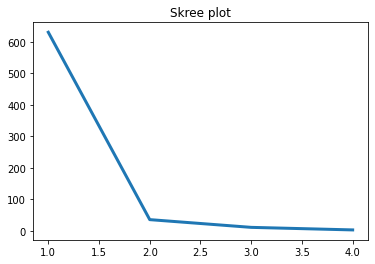

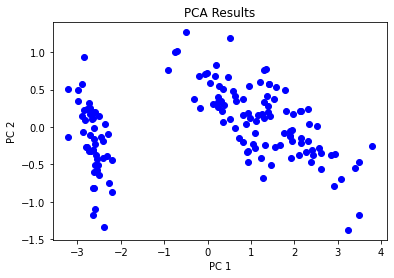

In [7]:
# Initialize PCA object
pca=my_PCA(n_comp=4)
# Fit data
pca.fit(X)

X_transformed =pca.transform(X)

# Get Skree plot
pca.variance_explained()
# Embed data (projection)
# ...
# Plot PCA results with first 2 PC

plt.scatter(X_transformed[:,0], X_transformed[:,1], c='blue')
plt.title('PCA Results')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

Now, compare your result by using sklearn PCA on the same data (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Don't worry if the plot looks rotated: it happens that the eigenvectors might not be unique (often up to a sign).

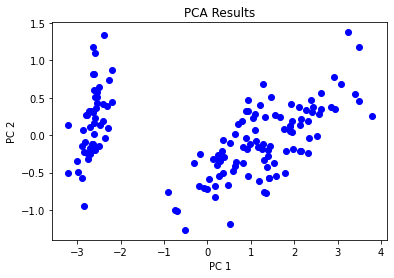

In [9]:
# Sklearn PCA
from sklearn.decomposition import PCA

# Fill code here 
# ...

# initalize PCA
iris_pca = PCA(n_components= 4)

# fit the data
iris_pca.fit(X)

# transform the data
X_transformed_sklearn = iris_pca.transform(X)
# Plot PCA results with first 2 PC
plt.scatter(X_transformed_sklearn[:,0], X_transformed_sklearn[:,1], c='blue')
plt.title('PCA Results')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

#### Try your PCA on a single-cell dataset 
We shared on the google drive a single-cell dataset of PBMCs (immune blood cells). The data has been preprocessed for you. The goal is to make you apply your tool to a real dataset, and try to interpret some of the results.

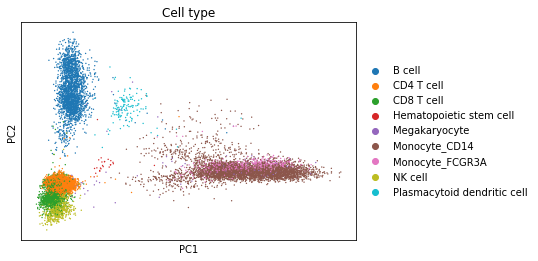

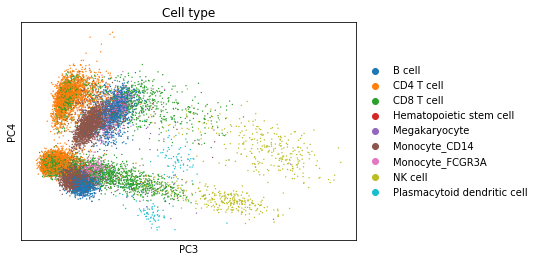

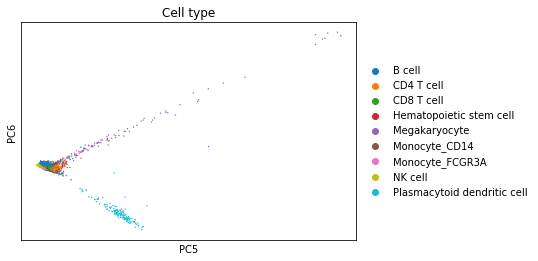

Index(['GeneName-0', 'GeneID-0', 'GeneName-1', 'GeneID-1', 'means',
       'dispersions', 'dispersions_norm'],
      dtype='object')


In [17]:
# Load PBMC data
adata = sc.read('adata_h5.h5ad')
# Extract data matrix from scanpy object
X_pbmc = adata.X
# Run your PCA with 50 components - fill code here
# ...
adata_pca = my_PCA(n_comp= 50)
adata_pca.fit(X_pbmc)
pca_transform = adata_pca.transform(X_pbmc)
# Plot with first 2 components - call scanpy plot function and color by cell type
adata.obsm.X_pca = pca_transform
# Plot PC1vsPC2 , PC3vsPC4 , PC5vsPC6
sc.pl.pca(adata, color='Cell type', components='1,2')
sc.pl.pca(adata, color='Cell type', components='3,4')
sc.pl.pca(adata, color='Cell type', components='5,6')

Notice that the amount of variance rapidly decreases as we include more PCs. Although we computed the transformation with 50 PCs here, we can therefore subset to fewer PCs for downstream analysis. 

### Questions

1.  Looking at how they are calculated, how many Principal Components (PCs) can you get at most ?
**You can get up to $p$ PCs. Where $p$ is the n_components parameter in PCA class, which can span up to the total number of parameters a single sample has.**
2. If you wanted to use PCA for reducing dimensionality but not for plotting, how would you choose the number of PCs to use?
**I would use the skree plot to see where the 'elbow' point is on the graph, the number where the line plot starts to flatten would be the ideal number of PCA's (dimensions) to use.**
3. Looking at the first PC in the Iris example, which 2 features would you say drives most of the variance across it? Same question for the PBMC data.
**The first two features PC1 and PC2 drove the most variance for the Iris data. For the PMBC data, PC1 and PC2 showed much stronger variance then the 3,4 and 5,6 pairings.**
4. In the context of single-cell RNA-seq(transcriptome with ~30000 genes), why would using PCA be a good idea?
**PCA would be useful because there is 3000 genes, meaning 3000 parameters, to reduce it to a two dimensional space, or 3 even. We can only focus on the dimensions that matter the most with the best variance.**
5. Why would you say that scaling features ($\mu=0$, $\sigma=1$) is a good idea prior to PCA ?
**This centers the data like a gaussian distribution, like a z score. To tell the end user how much the value is from the mean in terms of standard deviation.We could also align it with the z to probability table see the probablity of a certain point given the PC it is in.**
6. In the PBMC example, why do you think plotting with the first 2 principal components gives better separation results for the cell types than with other components (let say PC5 and PC6) ?
**This is because PC6 and PC5 had smaller covariance values in the cov matrix - making their associated eigenvalue and therefore the eigenvector smaller.**
7. Can you see why PCA is called a ‘linear’ dimensionality reduction method ?
**Yes, it depends on matrix dot products and finding eigenvalues and vectors for each component of the dataset.** 
8. (Bonus) Go on google and describe briefly another dimensionality reduction method of your choice. Contrast it with PCA. 



